In [1]:
!pip install -U Contractions
import nltk
nltk.download('all')


#Importing various libraries
import pandas as pd
import numpy as np
from numpy import array
from numpy import asarray
from numpy import zeros
import matplotlib.pyplot as plt
import re, string, unicodedata
import nltk
import contractions
#import inflect
from nltk import word_tokenize, sent_tokenize
from nltk.corpus import stopwords
from nltk.stem import LancasterStemmer, WordNetLemmatizer
from sklearn.utils import shuffle
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import Dropout
from keras.layers import Embedding
from keras.layers import Bidirectional
import keras 
from keras.layers import LSTM, CuDNNLSTM
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint
from keras.models import load_model
from keras.utils import to_categorical



#Ignoring the warnings
import warnings
warnings.filterwarnings(action = 'ignore') 



You are using pip version 19.0.3, however version 20.0.2 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.
[nltk_data] Downloading collection 'all'
[nltk_data]    | 
[nltk_data]    | Downloading package abc to /usr/share/nltk_data...
[nltk_data]    |   Package abc is already up-to-date!
[nltk_data]    | Downloading package alpino to /usr/share/nltk_data...
[nltk_data]    |   Package alpino is already up-to-date!
[nltk_data]    | Downloading package biocreative_ppi to
[nltk_data]    |     /usr/share/nltk_data...
[nltk_data]    |   Package biocreative_ppi is already up-to-date!
[nltk_data]    | Downloading package brown to /usr/share/nltk_data...
[nltk_data]    |   Package brown is already up-to-date!
[nltk_data]    | Downloading package brown_tei to
[nltk_data]    |     /usr/share/nltk_data...
[nltk_data]    |   Package brown_tei is already up-to-date!
[nltk_data]    | Downloading package cess_cat to
[nltk_data]    |     /usr/share/nltk_data...
[nl

Using TensorFlow backend.


In [2]:
#Reading the data
df2 = pd.read_csv('../input/training/data_combined_train.csv')
X = df2.iloc[:, 0:1].values
X_train = []
for i in X:
    for j in i:
        X_train.append(str(j))
y_train = df2.iloc[:, 1].values

In [3]:
def replace_contractions(sentence):
    """Replace contractions in string of text"""
    return contractions.fix(sentence)

  
def words_list(sample):
    words = []
    """Tokenising the corpus"""
    for i in sample: 
        temp = []
        for j in word_tokenize(i):
            temp.append(j.lower())
        temp = normalize(temp)
        words.append(temp)
    return words

  
def remove_non_ascii(words):
    """Remove non-ASCII characters from list of tokenized words"""
    new_words = []
    for word in words:
        new_word = unicodedata.normalize('NFKD', word).encode('ascii', 'ignore').decode('utf-8', 'ignore')
        new_words.append(new_word)
    return new_words

  
def to_lowercase(words):
    """Convert all characters to lowercase from list of tokenized words"""
    new_words = []
    for word in words:
        new_word = word.lower()
        new_words.append(new_word)
    return new_words

  
def remove_punctuation(words):
    """Remove punctuation from list of tokenized words"""
    new_words = []
    for word in words:
        new_word = re.sub(r'[^\w\s]', '', word)
        if new_word != '':
            new_words.append(new_word)
    return new_words

"""def replace_numbers(words):
    Replace all interger occurrences in list of tokenized words with textual representation
    p = inflect.engine()
    new_words = []
    for word in words:
        if word.isdigit():
            new_word = p.number_to_words(word)
            new_words.append(new_word)
        else:
            new_words.append(word)
    return new_words
"""


def remove_stopwords(words):
    """Remove stop words from list of tokenized words"""
    new_words = []
    for word in words:
        if word not in stopwords.words('english'):
            new_words.append(word)
    return new_words

  
def lemmatize_words(words):
    """Lemmatize the words"""
    lemmatizer = WordNetLemmatizer()
    lemmas = []
    for word in words:
        lemma = lemmatizer.lemmatize(word)
        lemmas.append(lemma)
    return lemmas

 
def normalize(words):
    """This is the main function which takes all other functions to pre-process the data given"""
    words = remove_non_ascii(words)
    words = to_lowercase(words)
    words = remove_punctuation(words)
    words = remove_stopwords(words)
    lemmatize_words(words)
    return words


In [4]:
vocab_size = 100000
# cut texts after this number of words
# (among top max_features most common words)
maxlen = 130
batch_size = 32
word_list = words_list(X_train)
X_train = []
for list_of_words in word_list:
    sentence = ' '.join(x for x in list_of_words)
    X_train.append(sentence)
X_train, y_train = shuffle(X_train, y_train)
t = Tokenizer()
t.fit_on_texts(X_train)
encoded_word_list = t.texts_to_sequences(X_train)
X_train = pad_sequences(encoded_word_list, maxlen=maxlen, padding='post')


In [5]:
#Managing the y vector
y_train = to_categorical(y_train, num_classes = 10)
print(y_train[0])

#Regularization
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=20)
mc = ModelCheckpoint('best_model.h5', monitor='val_acc', mode='max', verbose=1, save_best_only=True)


[0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]


In [6]:
#Constructing and training the model
model = Sequential()
e = Embedding(input_dim = vocab_size, output_dim = 100, input_length = X_train.shape[1], dropout=0.2)  #130*100 Output
model.add(e)
tensors = model.add(Bidirectional(CuDNNLSTM(128, return_sequences = False)))
model.add(Dropout(0.2))
model.add(Dense(10, activation = 'softmax'))
model.summary()
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
history = model.fit(X_train, y_train, epochs=3, batch_size=batch_size, verbose=1, validation_split=0.1, callbacks=[es, mc])

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 130, 100)          10000000  
_________________________________________________________________
bidirectional_1 (Bidirection (None, 256)               235520    
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 10)                2570      
Total params: 10,238,090
Trainable params: 10,238,090
Non-trainable params: 0
_________________________________________________________________
Instructions for updating:
Use tf.cast instead.
Train on 449999 samples, va

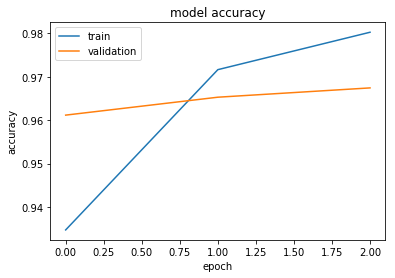

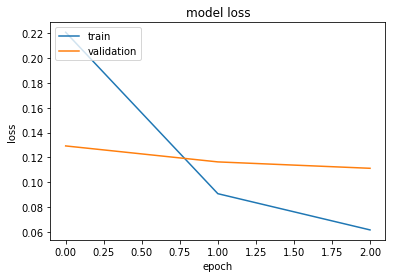

In [7]:
#Plotting the results
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [8]:
#Testing
dataset2 = pd.read_csv('../input/training/data_combined_train.csv')
X_test_init = dataset2.iloc[:, 0:1].values
y_test = dataset2.iloc[:, 1].values
X_test = []
for i in X_test_init:
    for j in i:
        X_test.append(str(j))
word_list = words_list(X_test)
X_test = []
for list_of_words in word_list:
    sentence = ' '.join(x for x in list_of_words)
    X_test.append(sentence)
encoded_word_list = t.texts_to_sequences(X_test)
X_test = pad_sequences(encoded_word_list, maxlen=maxlen, padding='post')
#Managing the y vector
y_test = to_categorical(y_test, num_classes = 10)
score, acc = model.evaluate(X_test, y_test, batch_size = batch_size, verbose = 1)
print("The accuracy of the model on the test set is: ", acc, score)

499999/499999 [==============================] - 79s 158us/step
The accuracy of the model on the test set is:  0.9855999712000616 0.04438227449676242


In [9]:
#Confusion Matrix
y_pred = model.predict(X_test)
y_pred = [ np.argmax(t) for t in y_pred ]
y_test_non_category = [ np.argmax(t) for t in y_test]
from sklearn.metrics import confusion_matrix
conf_mat = confusion_matrix(y_test_non_category, y_pred)
print(conf_mat)

[[49880    38     4    33     2     4     5    12    14     8]
 [   41 49806    12     4     7     6    59     5    58     2]
 [    8    35 49464    93    24    31   270    28     9    37]
 [   49     9   203 48034   355   168   132   418     0   632]
 [   23    11    33   297 49406    25    39    89     6    71]
 [   23     3   192    80    25 49403    40   155     5    74]
 [   11   171   290    30    54    20 49381    22     3    18]
 [  249    17    49   260    34    32    19 49155     4   181]
 [    9     7    17     5     3     2     3     0 49951     3]
 [   43    14    68   797    98   267   103   281    10 48319]]


In [10]:
#Dictionary of Class names and their index as in labels
label_name = {0: 'Acupuncture', 
              1: 'Chiropractic',
              2: 'Diagnostic Lab',
              3: 'Emergency Services',
              4: 'Human Resource Contact',
              5: 'Maternity',
              6: 'MRI-CAT Scan',
              7: 'Pharmacy Benefit Manager',
              8: 'Physician Visit Office Sick',
              9: 'Psychiatric Out-patient'}

In [11]:
s1 = ['Can you tell me the status of my claims for emergency services?']
word_list = words_list(s1)
X_test = []
for list_of_words in word_list:
    sentence = ' '.join(x for x in list_of_words)
    X_test.append(sentence)
encoded_word_list = t.texts_to_sequences(X_test)
s2 = pad_sequences(encoded_word_list, maxlen=40, padding='pre')
pred = model.predict(s2)
print(pred)
pred = np.argmax(pred)
print('TextRNN : ', label_name[pred])

ValueError: Error when checking input: expected embedding_1_input to have shape (130,) but got array with shape (40,)